In [ ]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langchain_experimental langsmith pandas tiktoken openai pydantic matplotlib seaborn

In [ ]:
from getpass import getpass
import os
from typing import Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tiktoken
from openai import OpenAI
from pydantic import BaseModel

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")

You need an OpenAI API KEY - https://www.maisieai.com/help/how-to-get-an-openai-api-key-for-chatgpt

NOTE: You will probably need to add some credits in case you don't get it for free after create the account. 50NOK should be good enough to do all the tests. This API consumption is very low and we are using a very cheap model

In [ ]:
_set_if_undefined("OPENAI_API_KEY")

Please provide your OPENAI_API_KEY··········


In [ ]:
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:
def cosine_similarity_percentage(embedding1, embedding2):
    unit_vector1 = embedding1 / np.linalg.norm(embedding1)
    unit_vector2 = embedding2 / np.linalg.norm(embedding2)
    similarity = np.dot(unit_vector1, unit_vector2)
    similarity_percentage = similarity * 100
    return similarity_percentage

In [ ]:
client = OpenAI()

In [ ]:
class TextInfo(BaseModel):
    stage: str
    text: str
    tokens: int
    words: int
    characters: int
    embedding: Any

    @staticmethod
    def create(text: str, stage: str = "original") -> "TextInfo":
        return TextInfo(
            stage=stage,
            text=text,
            tokens=num_tokens_from_string(text),
            words=len(text.split()),
            characters=len(text),
            embedding=get_embedding(text)
        )

In [ ]:
def build_comparison_table(text_infos: List[TextInfo]) -> pd.DataFrame:
    return pd.DataFrame({
        "stage": [x.stage for x in text_infos],
        "text": [x.text for x in text_infos],
        "tokens": [x.tokens for x in text_infos],
        "words": [x.words for x in text_infos],
        "characters": [x.characters for x in text_infos],
    })

In [ ]:
def plot_similarity_matrix(text_infos: List[TextInfo]):
    n = len(text_infos)
    labels = [info.stage for info in text_infos]
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = cosine_similarity_percentage(text_infos[i].embedding, text_infos[j].embedding)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, vmin=0, vmax=100)
    plt.title("Cosine Similarity Matrix")
    plt.xlabel("Stage")
    plt.ylabel("Stage")
    plt.show()

In [ ]:
def apply_text_transformation(stage: str, text: str, prompt: str) -> TextInfo:
    prompt = ChatPromptTemplate.from_template(prompt)
    model = ChatOpenAI()
    output_parser = StrOutputParser()
    chain = prompt | model | output_parser
    transformed = chain.invoke({"input_text": text})
    return TextInfo.create(transformed, stage)

In [ ]:
def apply_compression(text_info: TextInfo) -> TextInfo:
    return apply_text_transformation(
        "compressed",
        text_info.text,
        """
Apply the following methodology to compress the provided text while preserving its core meaning:

---
# Methodology: Contextual and Semantic Compression of Textual Content

This section delineates our systematic approach to achieving contextual and semantic compression \
of textual content. Our objective is to distill sentences to their essence, ensuring the preservation \
of their original meaning while minimizing verbosity. This methodology leverages foundational \
linguistic principles and a deep understanding of context to eliminate superfluous elements without \
compromising the integrity of the information conveyed. It finds particular utility in applications \
requiring succinct communication, such as text summarization, transmissions in bandwidth-limited \
environments, or cognitive processing tasks.

## Content Identification

### Objective
To ascertain and highlight the primary message(s) inherent within the text.

### Procedure
An initial analysis of the text is conducted to identify its central themes or ideas. This preliminary \
step is crucial for setting the stage for effective compression, as it identifies the indispensable \
elements that must be retained to preserve the text's original intent and significance.

### Example
Consider the sentence, "Tablets are no longer just personal devices for watching movies and catching \
up on emails in your downtime." The primary message distilled from this sentence is the expanded utility \
of tablets beyond mere leisure activities.

## Elimination of Redundant or Supplementary Information

### Objective
To excise words or phrases that do not contribute meaningfully to the primary message.

### Procedure
The sentence undergoes a rigorous examination to remove any adjectives, adverbs, and subordinate clauses \
that serve only to embellish the narrative without adding substantive information. This refinement focuses \
attention on the core ideas.

### Example
The phrase "in your downtime" is identified as non-essential and subsequently removed.

## Simplification of Vocabulary

### Objective
To replace complex or niche terms with simpler, more universally comprehensible alternatives.

### Procedure
Terms characterized by complexity, professional jargon, or specificity are substituted with more accessible \
language, ensuring the compressed text remains intelligible to a wider audience.

### Example
"Personal devices" is streamlined to "for," and "watching movies and catching up on emails" to "movies/emails."

## Reduction to Key Phrases

### Objective
To distill sentences to their fundamental phrases, capturing their essence.

### Procedure
Sentences are deconstructed into their basic components—subjects, verbs, and objects—with only those \
critical for conveying the overarching message retained. This process prioritizes succinctness and clarity.

### Example
The sentence is condensed to "Tablets not just for movies/emails."

## Use of Symbols/Abbreviations

### Objective
To employ symbols or abbreviations for succinct representation of common words or ideas.

### Procedure
Commonly understood symbols or abbreviations are utilized to replace standard terms, further condensing \
the text without sacrificing clarity.

### Example
The use of "/" effectively conveys "and" or "or," efficiently compressing the phrase.

## Reassembly into Coherent Phrases

### Objective
To logically organize the simplified components into a coherent structure.

### Procedure
The distilled elements are sequentially arranged to ensure the compressed message retains logical \
flow and comprehensibility.

### Example
"Tablets not just for movies/emails" exemplifies the outcome of this thoughtful reassembly.

## Final Review for Content Integrity

### Objective
To confirm that the compressed text faithfully retains the complete meaning of the original.

### Procedure
The final compressed version is meticulously compared against the original text to ensure all critical \
information and its intended meaning are intact. Adjustments are made as necessary to uphold the \
integrity of the content.

### Example
The rephrased sentence accurately communicates the expanded functionality of tablets, demonstrating \
the compression's efficacy.

## Contextual Compression (Optional)

### Objective
To leverage implicit knowledge or shared context to omit explicit mentions of inferable information.

### Procedure
The anticipated background knowledge of the target audience is evaluated to discern which concepts \
might be considered common knowledge or easily inferred. Explicit references to such concepts are then \
eliminated, relying on the audience's inferential capabilities to grasp the compressed message \
within a shared context.

### Example
By presuming a mutual understanding of tablets' multifunctional capabilities, the phrase \
"Tablets for more than leisure" succinctly encapsulates the core message.
---

Your task is to apply this methodology to the following text and return only the final compressed version:

{input_text}
        """)

In [ ]:
def apply_expansion(text_info: TextInfo) -> TextInfo:
    return apply_text_transformation(
        "expanded",
        text_info.text,
        """
Apply the following methodology to expand the provided text:

---
# Methodology: Semantic Expansion of Compressed Textual Content

This section presents our methodology for the semantic expansion of compressed textual content, aimed \
at reconstructing the original or an equivalently detailed version of a text from its condensed form. \
The process emphasizes maintaining the semantic integrity and informational depth of the original \
content while expanding the compressed text. This methodology is vital for applications such as \
detailed document synthesis, enhancing comprehension, or facilitating deeper analysis of condensed texts.

## Understanding Compressed Content

### Objective
To interpret and comprehend the core meanings encapsulated within the compressed text.

### Procedure
Analyze the compressed text to discern its key messages, themes, and any abbreviated terms or symbols. \
This foundational understanding is critical for accurate expansion that aligns with the original text's intent.

### Example
Given the compressed phrase "Tablets not just for movies/emails," the interpretation recognizes tablets' \
multifunctional use beyond entertainment and communication.

## Reintroduction of Contextual Details

### Objective
To restore the specific details and contextual nuances that were omitted during compression.

### Procedure
Infer and reintegrate contextual elements relevant to the compressed content's subject matter, ensuring \
these additions enhance the text's clarity and depth without deviating from the original message.

### Example
Expanding "Tablets not just for movies/emails" might involve specifying alternative uses of tablets, \
such as "Tablets are used for a wide range of activities beyond watching movies and managing emails, including..."

## Vocabulary Enrichment

### Objective
To enhance the text's richness and precision by incorporating a diverse vocabulary.

### Procedure
Identify areas within the expanded text where the language can be diversified or specified to better \
convey the nuances of the original message. Replace or

augment simple terms with more descriptive language or specific jargon relevant to the text's context.

### Example
For the expanded content regarding tablets, "used for a wide range of activities" can be enriched to \
"serve diverse functions from educational purposes to professional productivity, illustrating their \
versatility beyond mere entertainment and communication."

## Reconstruction of Complex Sentences

### Objective
To rebuild the syntactic complexity of the original text, reflecting its structural depth and linguistic nuances.

### Procedure
Transform simplified sentence structures into more complex forms by reintroducing subordinate clauses, \
varied sentence types, and transitional phrases. This step ensures the expanded text mirrors the \
original's sophistication and style.

### Example
The basic sentence "Tablets serve diverse functions" can be reconstructed to "Tablets, once primarily \
seen as devices for leisure, have now emerged as versatile tools that serve a myriad of functions, \
ranging from education to professional productivity."

## Integration of Supplementary Information

### Objective
To incorporate additional information that supports or enhances the original message, providing a \
more comprehensive understanding.

### Procedure
Supplement the text with relevant data, examples, or explanations that were not present in the compressed \
version but are beneficial for achieving a fuller comprehension of the topic.

### Example
Adding to the tablet's expanded description, one might include "Recent advancements in tablet technology \
have further extended their capabilities, allowing for sophisticated applications such as graphic design, \
augmented reality experiences, and high-level computational tasks."

## Review for Semantic Fidelity

### Objective
To ensure that the expanded text faithfully represents the original content's meaning, context, and intent.

### Procedure
Compare the expanded text against the original (if available) or the intended message of the compressed \
version, making adjustments as necessary to maintain accuracy and completeness of information.

### Example
Reviewing the expanded tablet text to ensure it accurately reflects the evolution and multifunctionality \
of tablets without introducing misinterpretations or inaccuracies.

## Final Editing for Coherence and Flow

### Objective
To refine the expanded text for readability, ensuring it is logically structured and flows smoothly from \
one idea to the next.

### Procedure
Perform a final edit to adjust sentence transitions, coherence, and overall structure, ensuring the text \
is engaging and easy to follow.

### Example
Ensuring the expanded narrative on tablets smoothly transitions from discussing historical uses to current \
functionalities and future possibilities, providing a coherent and comprehensive overview.
---

Your task is to apply this methodology to the following text and return only the final expanded version:

{input_text}
        """)

In [ ]:
original_text = TextInfo.create(
    "Samsung DeX enables small businesses and enterprises alike to ditch their laptops and desktops, "
    "saving significant money. All professionals need to do is connect their DeX-enabled device to a "
    "monitor, keyboard and mouse, and with that, they have a complete workstation. By mirroring the "
    "display and navigation of a laptop, DeX allows you to work intuitively in multiple windows. You "
    "can even move windows around by dragging and dropping them, or right-clicking them as you would "
    "on a PC. Plus, Microsoft Office integration on the Galaxy Tab S9 series lets you create and edit "
    "documents on the go."
)

In [ ]:
compressed_text = apply_compression(original_text)

In [ ]:
expanded_text = apply_expansion(compressed_text)

In [ ]:
text_infos = [
    original_text,
    compressed_text,
    expanded_text
]

In [ ]:
build_comparison_table(text_infos)

,stage,text,tokens,words,characters
0,original,Samsung DeX enables small businesses and enter...,120,98,596
1,compressed,"Samsung DeX transforms workstations, replacing...",56,38,285
2,expanded,Samsung DeX revolutionizes workstations by ser...,92,74,537


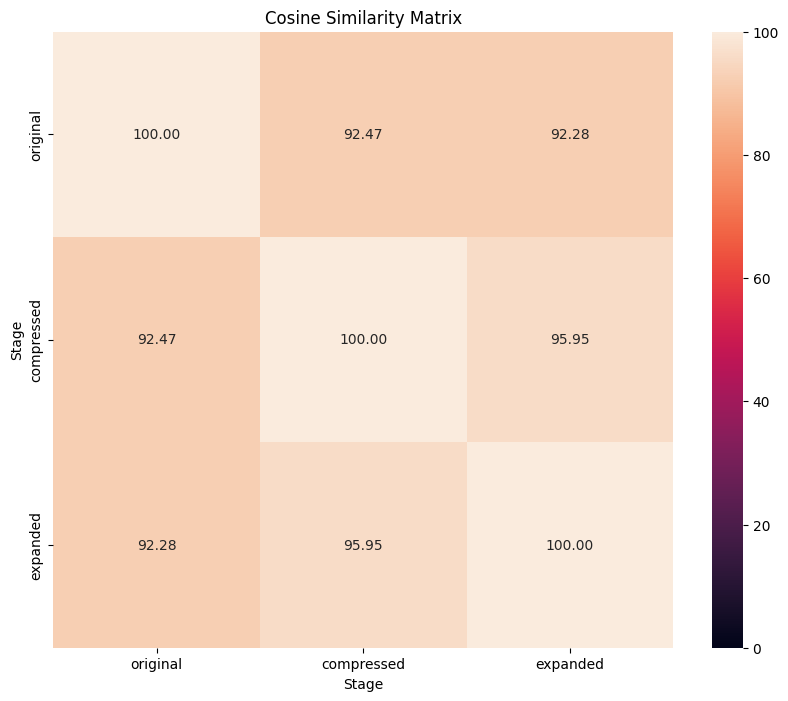

In [ ]:
plot_similarity_matrix(text_infos)